In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from candas.utils import dilute, setup_paths

base_pth, code_pth, data_pth, rslt_pth, fig_pth = setup_paths()
# plt.style.use(str(can.style.futura))

%config InlineBackend.figure_format = 'retina'

### Blocker Dilution

* 100 μM blocker stock
* 100 nM primers (final)
* 0x, 1x, 2x, 3x, 5x, 10x, 20x, 30x blocker (final)
* 10x pre-dilution -> 1-30 μM intermediate dilutions
* 50 μL pre-dilution volume

In [51]:
np.linspace(1.5, 0, 7)

array([1.5 , 1.25, 1.  , 0.75, 0.5 , 0.25, 0.  ])

In [52]:
lg_blocker_μM = np.linspace(1.5, 0, 7)
Vt, Vd, Vi = dilute(2, lg_blocker_μM, 50)

with np.printoptions(formatter={'float': '{: 7.1f}'.format}):
    print('μL Water:')
    print(Vd,'\n')
    print('μL Transferred:')
    print(Vt,'\n')
    print('μL Intermediate:')
    print(Vi,'\n')

μL Water:
[   76.7    48.4    47.2    45.0    41.1    34.2    21.9] 

μL Transferred:
[   35.5    62.2    60.6    57.8    52.8    43.9    28.1] 

μL Intermediate:
[  112.2   110.6   107.8   102.8    93.9    78.1    50.0] 



In [53]:
targets = ['S075_WT', 'S075_SNV']
primers = ['FP001', 'FP0013']
blockers = ['MMMMx','L-MMMMx']
configs = ['2+2', '7+2']
fluor = 'EVAGREEN'


lg_copies = np.arange(8,0,-1)

In [54]:
n_rows = 16
n_cols = (len(lg_blocker_μM)+1)*len(blockers)

ocols, orows = np.ogrid[0:n_rows, 0:n_cols]
mrows, mcols = np.mgrid[0:n_rows, 0:n_cols]

n_r = mrows.shape[0]
n_c = mrows.shape[1]

def make_df(plate_map, label):
    return pd.DataFrame(np.column_stack([mcols.flatten(), mrows.flatten(), plate_map.flatten()]), columns=['col', 'row', label])

def make_plate(plate_map, label, palette=None, **kwargs):
    df = make_df(plate_map, label)
    g = sns.relplot(data=df, x='col', y='row', hue=label, palette=palette, s=12**2, **kwargs)
    
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    ax = plt.gca()
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    xticks = np.arange(0,24)
    ax.set_xticks(xticks);
    ax.set_xticklabels(xticks+1)
    yticks = np.arange(0,16)
    ax.set_yticks(yticks);
    ax.set_yticklabels([chr(ord('A')+tick) for tick in yticks]);
    for _, spine in g.ax.spines.items():
        spine.set_visible(True)
        
    return df

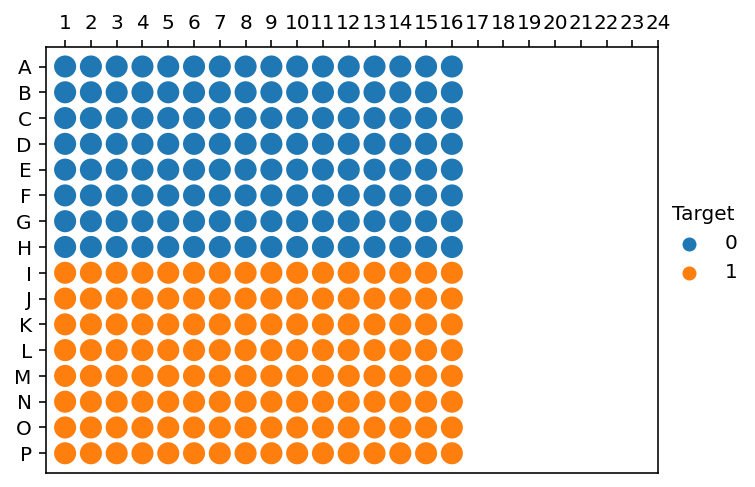

In [55]:
target_map = mrows//(n_rows//len(targets))
# target_map = np.kron(np.ones((n_r, n_c//8)), np.arange(8)).astype(int)
    
target_df = make_plate(target_map, 'Target')

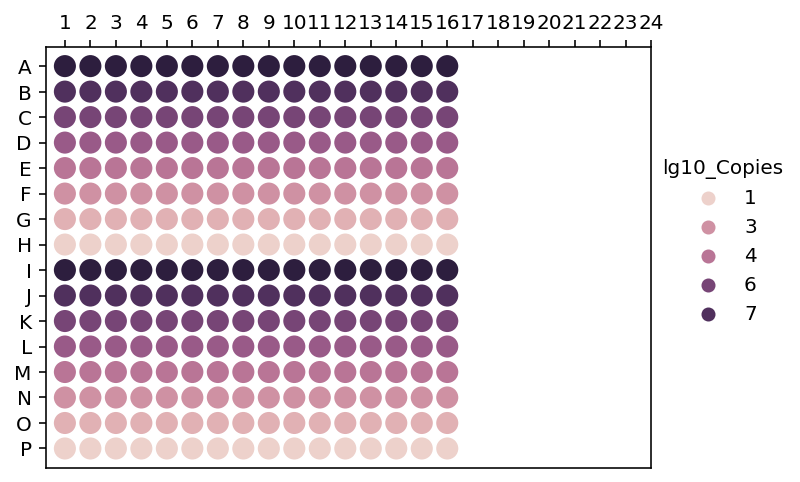

In [56]:
target_copy_map = np.tile(lg_copies[:,None], [len(targets), n_cols])
# target_map = np.kron(np.ones((n_r, n_c//8)), np.arange(8)).astype(int)
    
target_copy_df = make_plate(target_copy_map, 'lg10_Copies')

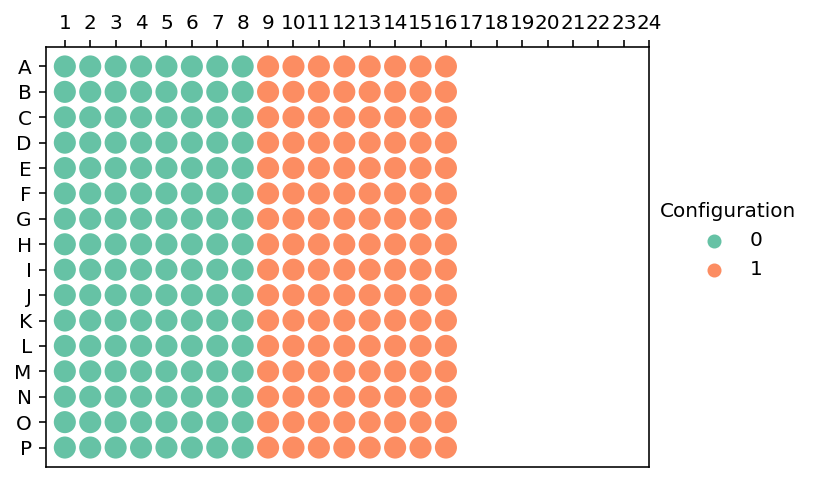

In [57]:
tri_config_map = mcols//(len(lg_blocker_μM)+1)
# target_map = np.kron(np.ones((n_r, n_c//8)), np.arange(8)).astype(int)
    
tri_config_df = make_plate(tri_config_map, 'Configuration', palette='Set2')

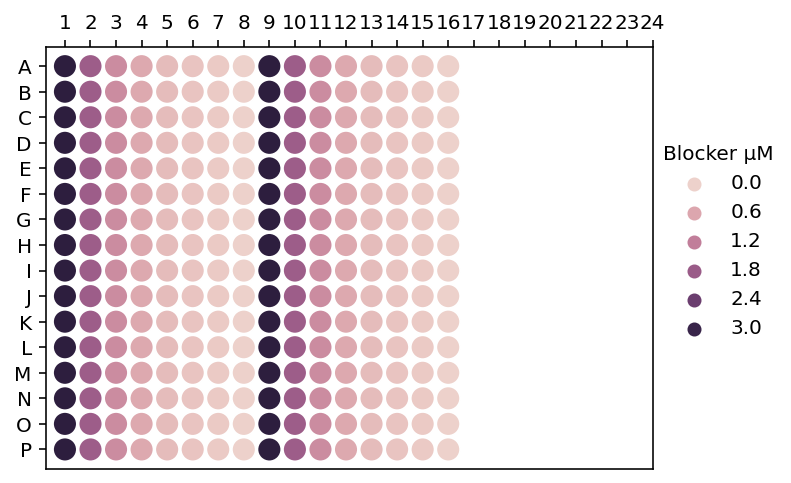

In [58]:
blocker_μM_map = np.tile(np.hstack([10**(lg_blocker_μM-1),0]), [n_rows, len(blockers)])
# target_map = np.kron(np.ones((n_r, n_c//8)), np.arange(8)).astype(int)
    
blocker_μM_df = make_plate(blocker_μM_map, 'Blocker μM')

# JG075B: L-MMMMx blocker 

In [65]:
experiment = 'JG075B'

rxns = (target_df
 .merge(target_copy_df)
 .merge(blocker_df)
 .merge(blocker_μM_df)
 .merge(tri_config_df)
 .assign(
     Well = lambda df: df.col+df.row*24+1,
     WellName = lambda df: (df.row + ord('A')).map(chr)+(df.col+1).map(str),
     Sample = lambda df: experiment+'_'+df.Well.map('{:03d}'.format),
     Blocker = 'L-MMMMx'
 )
 .drop(columns=['col','row'])
 .replace({
     'Target': {i: t for i, t in enumerate(targets)},
     'Configuration': {i: t for i, t in enumerate(configs)},
 })
)

rxns.to_csv(experiment + ' Plate Map.csv', index=False)
rxns

,Target,lg10_Copies,Blocker,Blocker μM,Configuration,Well,WellName,Sample
0,S075_WT,8,L-MMMMx,3.162278,2+2,1,A1,JG075B_001
1,S075_WT,8,L-MMMMx,1.778279,2+2,2,A2,JG075B_002
2,S075_WT,8,L-MMMMx,1.000000,2+2,3,A3,JG075B_003
3,S075_WT,8,L-MMMMx,0.562341,2+2,4,A4,JG075B_004
4,S075_WT,8,L-MMMMx,0.316228,2+2,5,A5,JG075B_005
...,...,...,...,...,...,...,...,...
251,S075_SNV,1,L-MMMMx,0.562341,7+2,372,P12,JG075B_372
252,S075_SNV,1,L-MMMMx,0.316228,7+2,373,P13,JG075B_373
253,S075_SNV,1,L-MMMMx,0.177828,7+2,374,P14,JG075B_374
254,S075_SNV,1,L-MMMMx,0.100000,7+2,375,P15,JG075B_375


In [60]:
filename = experiment + ' Plate Setup.txt'

with open(filename, 'w') as file:
    file.write('* Instrument Type = QuantStudio 6\n')
    file.write('* Passive Reference = ROX\n')
    file.write('[Sample Setup]\n')
    file.write('\t'.join(['Well', 'Target Name', 'Sample Name', 'Reporter', 'Quantity', 'Quencher', 'Task']) + '\n')
    
    for _, row in rxns.iterrows():
        file.write('\t'.join([str(row.Well), row.Target+'FAM', row.Sample, 'FAM', str(10**row.lg10_Copies), 'None', 'STANDARD']) + '\n')
        file.write('\t'.join([str(row.Well), row.Target+'HEX', row.Sample, 'HEX', str(10**row.lg10_Copies), 'None', 'STANDARD']) + '\n')

# JG075C: MMMMx blocker 

In [66]:
experiment = 'JG075C'

rxns = (target_df
 .merge(target_copy_df)
 .merge(blocker_df)
 .merge(blocker_μM_df)
 .merge(tri_config_df)
 .assign(
     Well = lambda df: df.col+df.row*24+1,
     WellName = lambda df: (df.row + ord('A')).map(chr)+(df.col+1).map(str),
     Sample = lambda df: experiment+'_'+df.Well.map('{:03d}'.format),
     Blocker = 'MMMMx'
 )
 .drop(columns=['col','row'])
 .replace({
     'Target': {i: t for i, t in enumerate(targets)},
     'Configuration': {i: t for i, t in enumerate(configs)},
 })
)

rxns.to_csv(experiment + ' Plate Map.csv', index=False)
rxns

,Target,lg10_Copies,Blocker,Blocker μM,Configuration,Well,WellName,Sample
0,S075_WT,8,MMMMx,3.162278,2+2,1,A1,JG075C_001
1,S075_WT,8,MMMMx,1.778279,2+2,2,A2,JG075C_002
2,S075_WT,8,MMMMx,1.000000,2+2,3,A3,JG075C_003
3,S075_WT,8,MMMMx,0.562341,2+2,4,A4,JG075C_004
4,S075_WT,8,MMMMx,0.316228,2+2,5,A5,JG075C_005
...,...,...,...,...,...,...,...,...
251,S075_SNV,1,MMMMx,0.562341,7+2,372,P12,JG075C_372
252,S075_SNV,1,MMMMx,0.316228,7+2,373,P13,JG075C_373
253,S075_SNV,1,MMMMx,0.177828,7+2,374,P14,JG075C_374
254,S075_SNV,1,MMMMx,0.100000,7+2,375,P15,JG075C_375


In [62]:
filename = experiment + ' Plate Setup.txt'

with open(filename, 'w') as file:
    file.write('* Instrument Type = QuantStudio 6\n')
    file.write('* Passive Reference = ROX\n')
    file.write('[Sample Setup]\n')
    file.write('\t'.join(['Well', 'Target Name', 'Sample Name', 'Reporter', 'Quantity', 'Quencher', 'Task']) + '\n')
    
    for _, row in rxns.iterrows():
        file.write('\t'.join([str(row.Well), row.Target+'FAM', row.Sample, 'FAM', str(10**row.lg10_Copies), 'None', 'STANDARD']) + '\n')
        file.write('\t'.join([str(row.Well), row.Target+'HEX', row.Sample, 'HEX', str(10**row.lg10_Copies), 'None', 'STANDARD']) + '\n')